In [1]:
# setup
import numpy as np
import pandas as pd
import scipy.stats as stats
import doubleml as dml
import statsmodels.api as sm
import patsy
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

In [ ]:
# load data
df = pd.read_csv("data/uplift_data_final.csv", index_col=0)

# missing values? standardized data? balance treatment and control?
print(df.head())
print(df.isnull().sum())
print(df.mean())
print(df.std())

   conversion  coupon        X0        X1        X2        X3        X4  \
0         1.0     1.0 -1.110554 -1.134097  0.128589  0.874238  0.196594   
1         0.0     1.0 -0.515260 -0.150295 -0.076850 -0.204064  0.362197   
2         0.0     0.0  1.160414 -0.345812  0.441647 -1.084716 -1.837146   
3         1.0     0.0 -2.141387 -1.960944 -1.598674 -0.887552 -1.632236   
4         0.0     1.0 -0.609404 -0.682008 -1.672801 -1.692626 -2.211051   

         X5        X6        X7  ...       X11       X12       X13       X14  \
0  2.040795  0.354033 -0.766300  ... -0.314289 -0.412576 -0.912329 -0.089548   
1  0.573354  0.192715  0.372288  ... -1.663128  0.623341  0.296811 -0.327026   
2 -1.207060 -1.399175  0.203727  ...  0.013339 -0.676666 -1.271227  1.215198   
3  0.681700  0.656121  0.350065  ...  0.389388  0.401734 -0.050694  0.278126   
4 -1.417280  0.670815  1.217301  ... -0.809787  0.067887  0.342862  1.054393   

   membership_level_0  membership_level_1  membership_level_2       

In [4]:
# true average treatment effect?  without causal analysis?
print("true average treatment effect:", df['ite'].mean()) 

treated = df[df['coupon'] == 1]
control = df[df['coupon'] == 0]
print("naive difference in conversion rates:", treated['conversion'].mean()- control['conversion'].mean())

# potential confounding? imbalance? correlation with treatment?
covariates = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
              'X11', 'X12', 'X13', 'X14']
for col in covariates:
    print(f"correlation between {col} and coupon:", np.corrcoef(df[col], df['coupon'])[0, 1])

true average treatment effect: 0.03908395919621665
naive difference in conversion rates: -0.020071941191220577
correlation between X0 and coupon: 0.018481828739076077
correlation between X1 and coupon: 0.008034546295127641
correlation between X2 and coupon: 0.02487746175698864
correlation between X3 and coupon: 0.044094632953325226
correlation between X4 and coupon: 0.06008973524142825
correlation between X5 and coupon: 0.11569101545631695
correlation between X6 and coupon: 0.09585159094710013
correlation between X7 and coupon: 0.1498084290646118
correlation between X8 and coupon: 0.20689439487009248
correlation between X9 and coupon: 0.12702288360936814
correlation between X10 and coupon: 0.14751202127925872
correlation between X11 and coupon: 0.10992197370724054
correlation between X12 and coupon: 0.14475091349319172
correlation between X13 and coupon: 0.12338138760930167
correlation between X14 and coupon: 0.06124696264329803


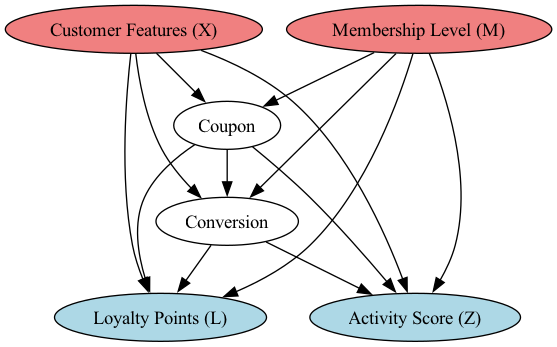

In [6]:
# causal analysis, first step causal graph
from graphviz import Digraph
from IPython.display import Image

dot = Digraph()
dot.attr(rankdir='TB')

with dot.subgraph() as top:
    top.attr(rank='same')
    top.node('X', 'Customer Features (X)', style='filled', fillcolor='lightcoral')
    top.node('M', 'Membership Level (M)', style='filled', fillcolor='lightcoral')

dot.node('C', 'Coupon')
dot.node('Y', 'Conversion')

with dot.subgraph() as bottom:
    bottom.attr(rank='same')
    bottom.node('L', 'Loyalty Points (L)', style='filled', fillcolor='lightblue')
    bottom.node('Z', 'Activity Score (Z)', style='filled', fillcolor='lightblue')

dot.edges([('X', 'C'), ('M', 'C'),
           ('X', 'Y'), ('M', 'Y'),
           ('C', 'Y'),
           ('C', 'L'), ('C', 'Z'),
           ('Y', 'L'), ('Y', 'Z'),
           ('X', 'L'), ('M', 'L'),
           ('X', 'Z'), ('M', 'Z')])

dot.render('dag', format='png', cleanup=True)
Image('dag.png')

In [7]:
# backdoor adjustment set
adjustment_set = covariates + ['membership_level_0', 'membership_level_1', 'membership_level_2']

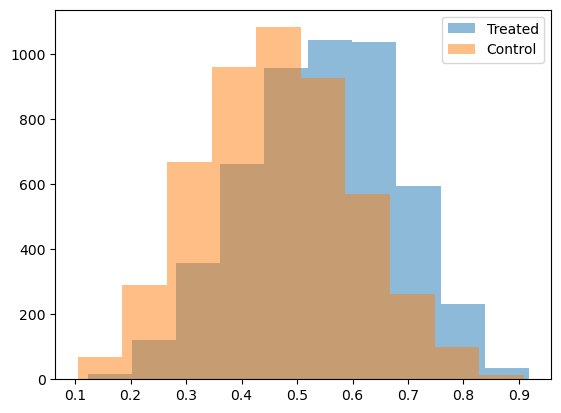

ipw estimated ATE: 0.010870724339120993
true average treatment effect: 0.03908395919621665


In [9]:
# ATE estimation using different methods

# ipw 
prop_model = LogisticRegression(max_iter=1000)
prop_model.fit(df[adjustment_set], df['coupon'])  
propensity = prop_model.predict_proba(df[adjustment_set])[:, 1]

plt.hist(propensity[df['coupon']==1], alpha=0.5, label='Treated')
plt.hist(propensity[df['coupon']==0], alpha=0.5, label='Control')
plt.legend() 
plt.show()

ate_iwp = np.mean((df['coupon'] * df['conversion']) / propensity - ((1 - df['coupon']) * df['conversion']) / (1 - propensity))
print("ipw estimated ATE:", ate_iwp)
print("true average treatment effect:", df['ite'].mean()) 

In [10]:
# logistic regression 
outcome_model = LogisticRegression(max_iter=1000)
outcome_model.fit(df[adjustment_set + ['coupon'] ], df['conversion'])

y_hat_1 = outcome_model.predict_proba(df[adjustment_set + ['coupon'] ].assign(coupon=1))[:, 1]
y_hat_0 = outcome_model.predict_proba(df[adjustment_set + ['coupon'] ].assign(coupon=0))[:, 1]
ate_lr = (y_hat_1-y_hat_0).mean()
print("logistic regression estimated ATE:", ate_lr)
print("true average treatment effect:", df['ite'].mean()) 

logistic regression estimated ATE: 0.011909259494919312
true average treatment effect: 0.03908395919621665


In [12]:
# doubly robust estimation (here usimg doubleml)

# logistic regression (simple)
treatment_model = LogisticRegression(max_iter=1000)
outcome_model = LogisticRegression(max_iter=1000)

dml_data = dml.DoubleMLData(df, y_col='conversion', d_cols='coupon',
                        x_cols=adjustment_set)

dml_irm_lr = dml.DoubleMLIRM(dml_data,
                          ml_g=outcome_model,
                          ml_m=treatment_model,
                          n_folds=5)

dml_irm_lr.fit()
print("double logistic regression estimated ATE:\n", dml_irm_lr.summary)
print("true average treatment effect:", df['ite'].mean()) 

double logistic regression estimated ATE:
             coef  std err        t    P>|t|     2.5 %   97.5 %
coupon  0.011841  0.00953  1.24248  0.21406 -0.006838  0.03052
true average treatment effect: 0.03908395919621665


In [13]:
# random forest (more involved)
treatment_model = RandomForestClassifier(n_estimators=500)
outcome_model = RandomForestRegressor(n_estimators=500)

dml_irm_rf = dml.DoubleMLIRM(dml_data,
                          ml_g=outcome_model,
                          ml_m=treatment_model,
                          n_folds=5)

dml_irm_rf.fit()
print("double random forest estimated ATE:\n", dml_irm_rf.summary)
print("true average treatment effect:", df['ite'].mean()) 

double random forest estimated ATE:
             coef   std err         t    P>|t|     2.5 %    97.5 %
coupon  0.028651  0.009345  3.065921  0.00217  0.010335  0.046966
true average treatment effect: 0.03908395919621665


In [16]:
# GATE estimation by membership level 
membership_level = df[['membership_level_0', 'membership_level_1', 'membership_level_2']].astype('bool')
gate = dml_irm_rf.gate(groups=membership_level)
print("double random forest estimated GATE:\n", gate)

for level in ['membership_level_0', 'membership_level_1', 'membership_level_2']:
    print(f"true GATE {level}: {df['ite'][df[level] == 1].mean()}")

double random forest estimated GATE:
 ================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
                        coef   std err         t     P>|t|    [0.025    0.975]
membership_level_0  0.047169  0.014944  3.156298  0.001598  0.017879  0.076460
membership_level_1  0.016744  0.014529  1.152422  0.249148 -0.011733  0.045220
membership_level_2  0.015887  0.021106  0.752709  0.451625 -0.025480  0.057253
true GATE membership_level_0: 0.06297299239315964
true GATE membership_level_1: 0.025669719591681534
true GATE membership_level_2: 0.018707844852900623


================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t         P>|t|    [0.025    0.975]
0  0.028170  0.009321  3.022285  2.508742e-03  0.009902  0.046439
1 -0.057558  0.009268 -6.210573  5.279179e-10 -0.075722 -0.039393


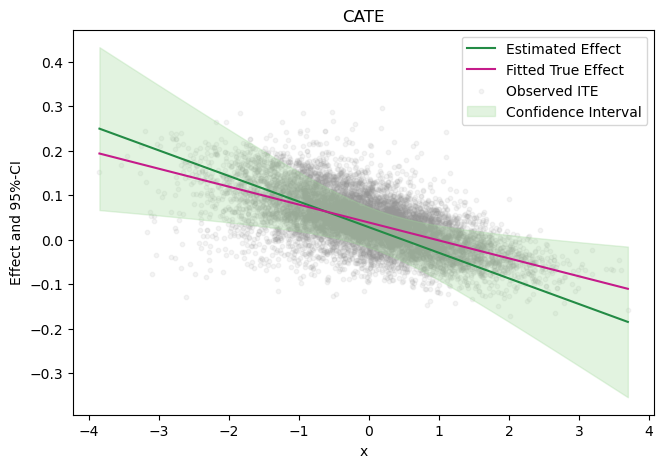

In [23]:
# CATE estimation by X10 (linear projection)
design_matrix=patsy.dmatrix("x", {"x": df['X10']})
spline_basis = pd.DataFrame(design_matrix)
cate = dml_irm_rf.cate(spline_basis)
print(cate)

# visualization 
x_grid = {"x": np.linspace(min(df['X10']), max(df['X10']), 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], x_grid)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)

df_cate['x'] = x_grid['x']
true_fitted_spline = sm.OLS(df['ite'], spline_basis).fit()
df_cate['ite_fitted'] = true_fitted_spline.predict(spline_grid)

fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], color='#238B45', label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['ite_fitted'], color='#C51B8A', label='Fitted True Effect')
ax.scatter(df['X10'], df['ite'], color='#969696', alpha=0.1, s=10, label='Observed ITE', zorder=1)
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='#A1D99B', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

plt.show()

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t         P>|t|    [0.025    0.975]
0  0.047595  0.011584  4.108646  3.979852e-05  0.024891  0.070299
1 -0.044165  0.008693 -5.080710  3.760276e-07 -0.061202 -0.027127
2 -0.019564  0.005989 -3.266684  1.088151e-03 -0.031302 -0.007826


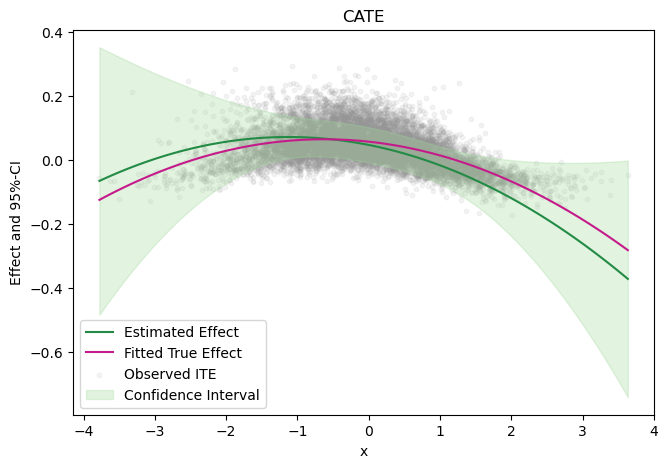

In [24]:
# CATE estimation by X11 (quadratic projection)
design_matrix=patsy.dmatrix("x + I(x**2)", {"x": df['X11']})
spline_basis = pd.DataFrame(design_matrix)
cate = dml_irm_rf.cate(spline_basis)
print(cate)

# visualization 
x_grid = {"x": np.linspace(min(df['X11']), max(df['X11']), 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], x_grid)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)

df_cate['x'] = x_grid['x']
true_fitted_spline = sm.OLS(df['ite'], spline_basis).fit()
df_cate['ite_fitted'] = true_fitted_spline.predict(spline_grid)

fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], color='#238B45', label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['ite_fitted'], color='#C51B8A', label='Fitted True Effect')
ax.scatter(df['X11'], df['ite'], color='#969696', alpha=0.1, s=10, label='Observed ITE', zorder=1)
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='#A1D99B', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

plt.show()